<a href="https://colab.research.google.com/github/rickragv/llm-playground/blob/main/bert-finetune-multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tokenizers transformers  --no-cache-dir

In [2]:
!pip install tokenizers -q

In [3]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup


In [4]:

import torch,tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
df = pd.read_csv('./yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [8]:
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4


# df['sentiment'] = df.score.apply(map_sentiment_scores)

df['stars'] = df.stars.apply(map_sentiment_scores)

In [9]:
''''
class_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star' ]

ax = sns.countplot(df.stars)
plt.xlabel('review stars')
ax.set_xticklabels(class_names)
'''

"'\nclass_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star' ]\n\nax = sns.countplot(df.stars)\nplt.xlabel('review stars')\nax.set_xticklabels(class_names)\n"

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size = 0.20, random_state = 0)
X_train.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
7389,K8pM6qQdYu5h6buRE1-_sw,2009-08-11,9fCs-xw3C4UQE9nqNeGFXw,4,A hole in the wall in South Phoenix.... \r\n\r...,review,k2n8CdqJhZqZT_w36rzang,1,0,0
9275,JhupPnWfNlMJivnWB5druA,2012-06-25,ob34u8KC1_omPQRIg-2fDw,3,AZ 88 was a great experience all around. It's ...,review,gqxJR_3_NkNypzS678QPuQ,0,0,0
2995,Dim6R6ki5Z_05bk_V1htbQ,2011-04-05,7jjswzK5bVu19AjlxTx4bQ,0,I got on the internet and looked at the menu a...,review,tGZPH2vrrxp20oA3fESE1g,0,1,0
5316,c0zhbiffge6fGl_Nzgxbqw,2008-08-20,Qt0QQvOCLO35QSMS_wCNVg,4,"I found some great t-shirts for friends here, ...",review,8eNEP7Yj7JwfOQPwgh4Prw,2,2,1
356,VEojEXbJ81eiPLSSF9jNEQ,2008-08-13,8ZC2ymJRf81mGgRKpBWOmQ,3,It has been several months but I hadn't lost t...,review,J72XoQspNBmPsX2iKl2YvA,2,2,1


In [11]:
from transformers import glue_convert_examples_to_features


In [12]:
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange
import time
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def get_features(df, text_col, label_col):
    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for
       idx, row in df.iterrows()]
    features = glue_convert_examples_to_features(examples=l,
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
train_dataset = get_features(X_train, 'text', 'stars')
test_dataset = get_features(X_test, 'text', 'stars')

/usr/local/lib/python3.10/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [14]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [18]:
from transformers import BertForSequenceClassification
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
hidden_size = 200
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=hidden_size)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda();

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model trainable parameters 108465077
Total head trainable parameters 154805


In [19]:
model(input_ids=train_dataset[:2][0].cuda(),
      attention_mask=train_dataset[:2][1].cuda(),
      labels=train_dataset[:2][2].cuda());

In [21]:
from torch import nn, optim
batch_size = 16
gradient_every = 32
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)



lr = 0.002
optimizer = optim.AdamW(model.classifier.parameters(), lr=lr)

In [38]:
epochs = 2
tr_losses = []
v_losses = []

In [39]:

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader)*epochs)
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda(),'return_dict':False}
        loss, _ = model(**feed_dict)
        #print(type(loss),type(_),loss)

        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/450 [00:00<?, ?it/s]

train NLL loss: 1.387646830479304
epoch 2


batch:   0%|          | 0/450 [00:00<?, ?it/s]

train NLL loss: 1.3584940871927473


In [45]:
epoch_v_losses = []
with torch.no_grad():
  for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
    feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda(),'return_dict':False}

    loss, pred = model(**feed_dict)
    epoch_v_losses.append(loss.item())
    v_losses.append(np.mean(epoch_v_losses))
print(f'validation BCE loss: {np.mean(epoch_v_losses)}')

val batch:   0%|          | 0/25 [00:00<?, ?it/s]

validation BCE loss: 1.4782892179489135


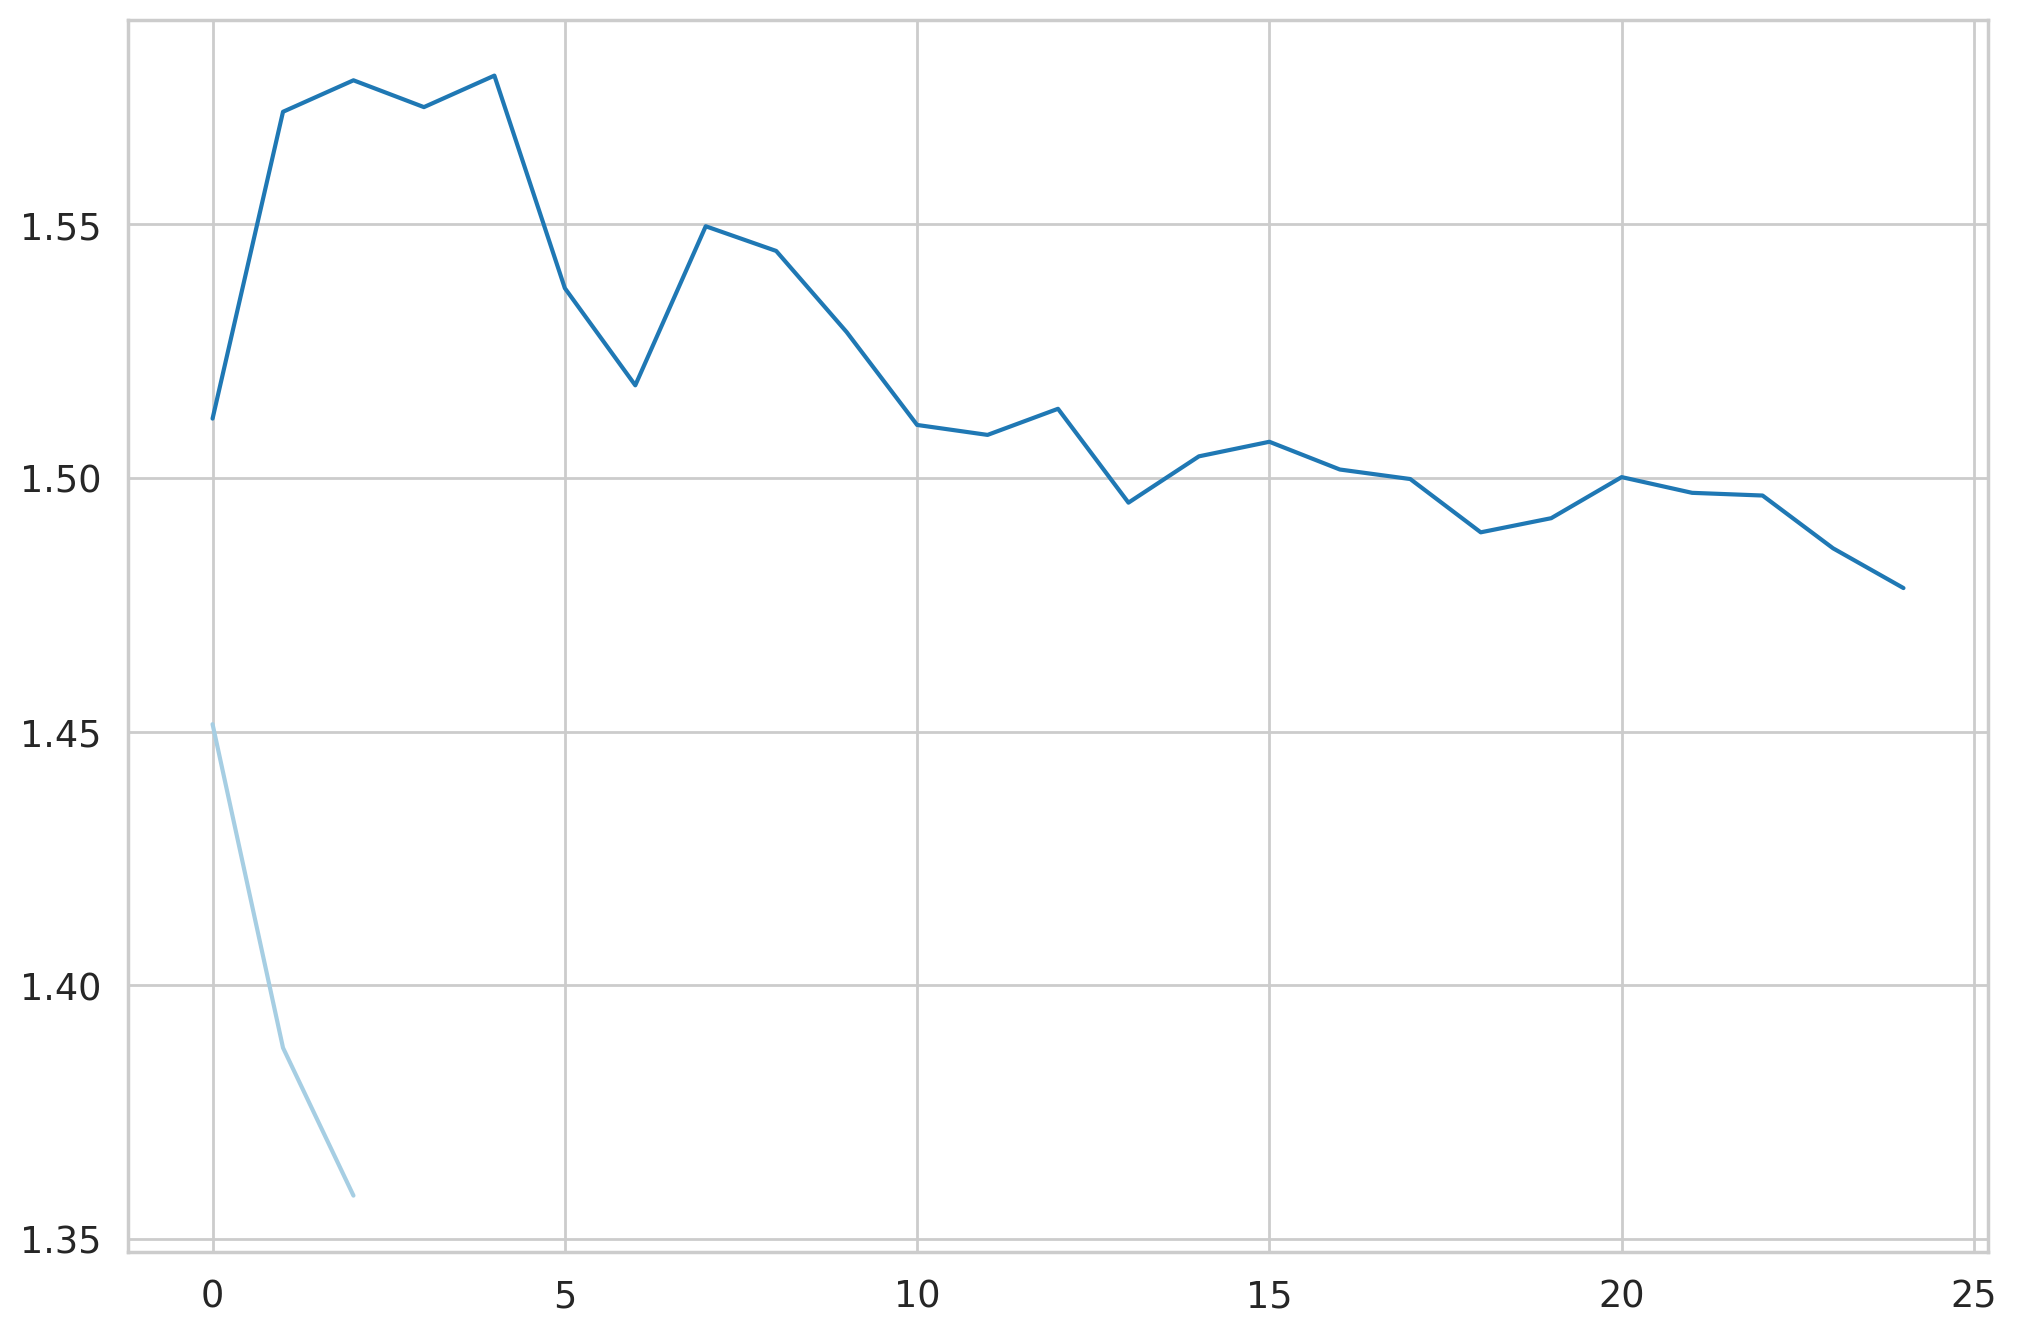

In [46]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [41]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()}

        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/63 [00:00<?, ?it/s]

In [42]:
predictions = np.array([i for k in batch_predictions for i in k ])

predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])
from sklearn.metrics import f1_score
f1_score(actual, predictions, average='micro')

0.418

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

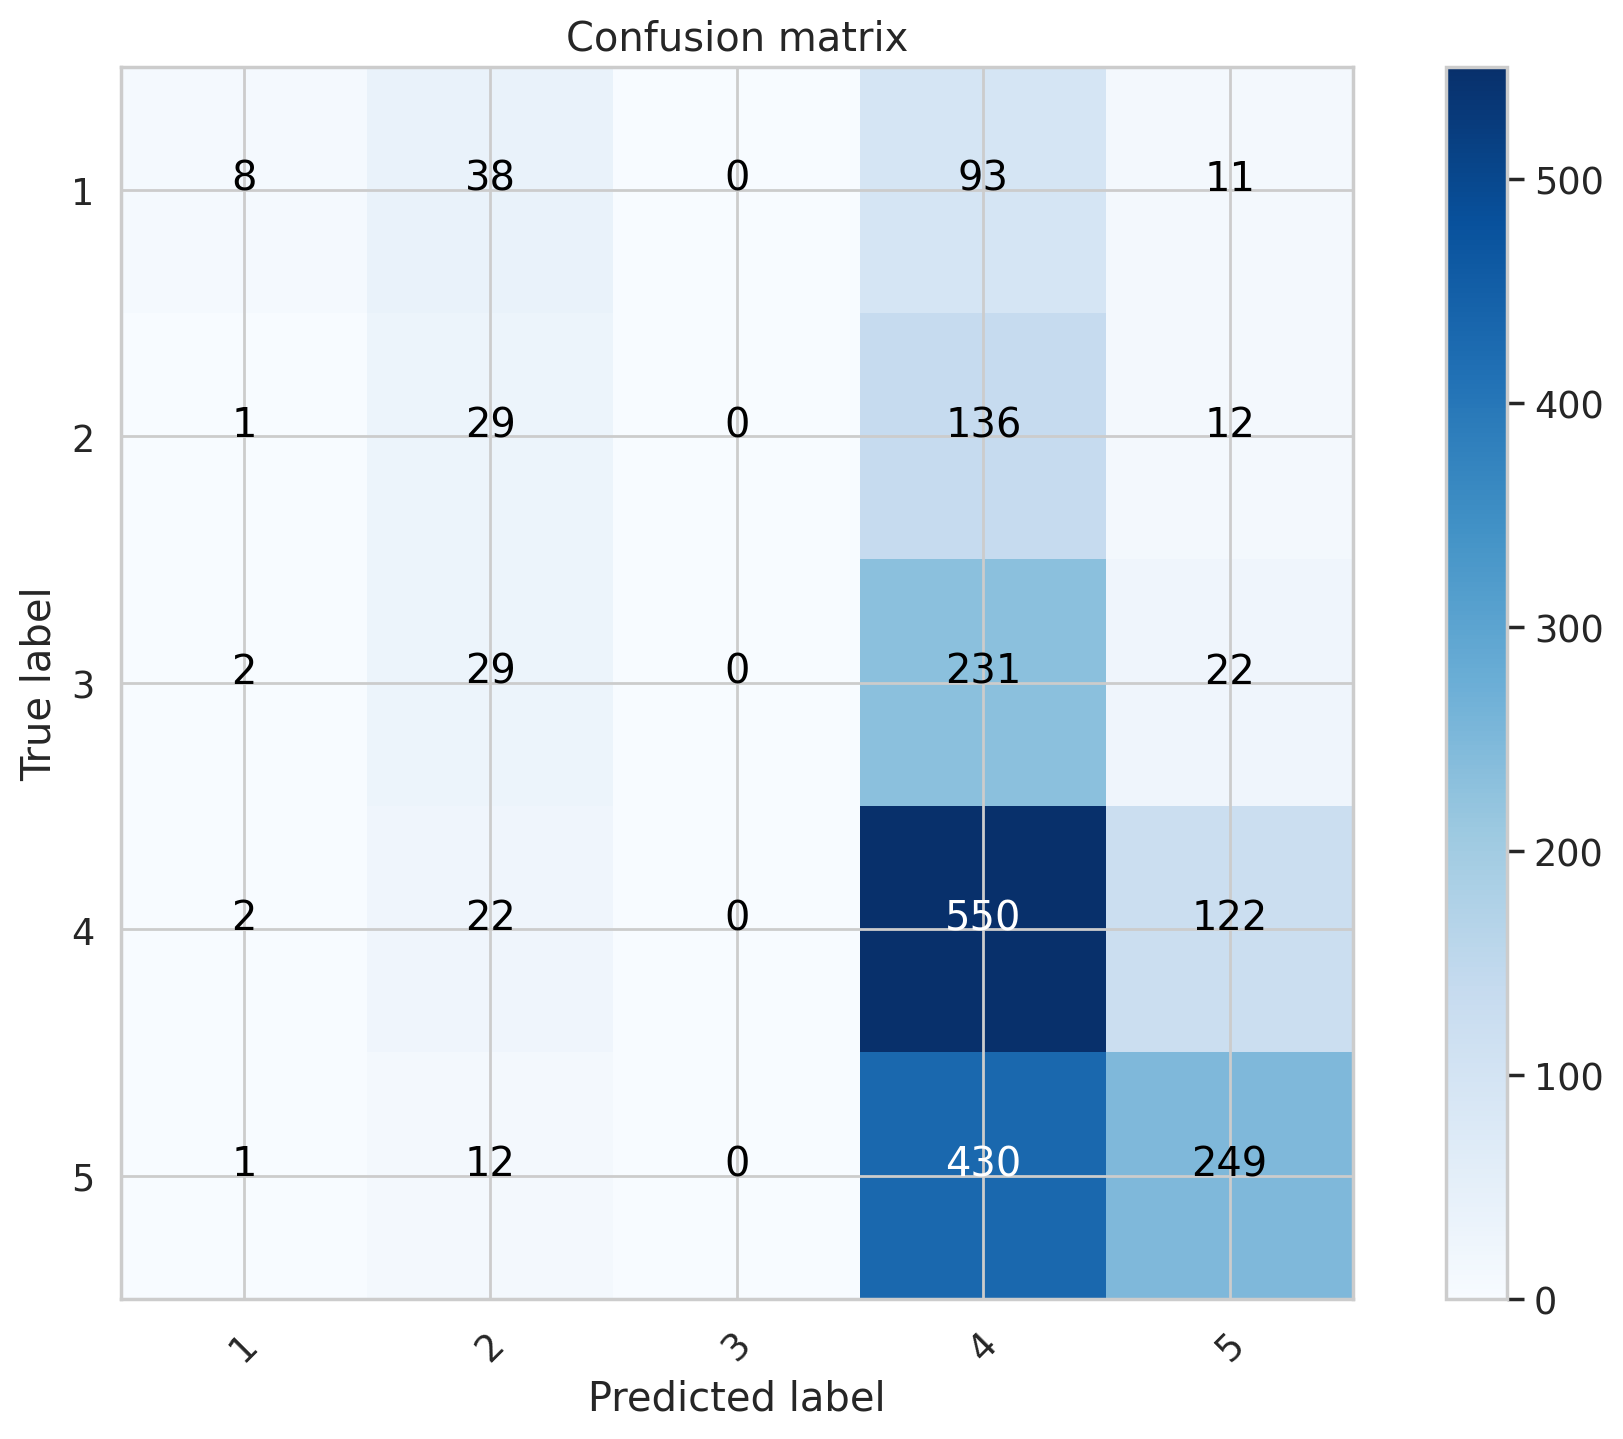

In [44]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()